<a href="https://colab.research.google.com/github/hobbit0701/hobbit/blob/main/Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 專案報告:Gemini 導師

## 專案目標


### 專案目標  
- 建立一個具備對話能力的 LINE Bot，並可透過 Google Gemini API 回應使用者提問。  
- 透過文章閱讀,藉由回答問題提升對於知識之理解



## 系統設計與架構



### 系統功能分析  

| 功能項目 | 說明 |
|----------|------|
| 使用者訊息接收 | 使用者透過 LINE 傳送訊息，Bot 接收並處理 |
| Gemini API 連接 | 將使用者訊息轉交至 Google Gemini 並取得 AI 回覆 |
| 回應傳送 | Bot 將 Gemini 的回應以文字方式回傳給使用者 |



### 使用的技術  

| 技術項目 | 說明 |
|----------|------|
| 程式語言 | Python |
| 框架 | Flask（建立 webhook） |
| 部署平台 | Versel |
| API 使用 | Google Gemini API（文字生成），LINE Messaging API（對話） |


## 專案成果與效益

### 系統程式

In [ ]:
!pip install -q flask pyngrok flask_ngrok line-bot-sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.1/776.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 9.5 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
from flask import Flask, request, abort
from pyngrok import ngrok
from flask_ngrok import run_with_ngrok

from linebot.v3 import WebhookHandler
from linebot.v3.exceptions import InvalidSignatureError
from linebot.v3.messaging import (
    Configuration,
    ApiClient,
    MessagingApi,
    ReplyMessageRequest,
    TextMessage
)
from linebot.v3.webhooks import MessageEvent, TextMessageContent, FollowEvent

import google.generativeai as genai

text = '''
### 古典經濟學派
你也許沒聽過「古典經濟學派」，但你很可能聽過另1個名詞，叫做「看不見的手」！「看不見的手」意思就是市場機制會因為供給需求的狀況，而自動調節出一個最終成交的價格。這個價格不是政府規定、更不是誰講好的，而是市場參與者透過交易自動形成的最終結果。

舉例來說：過去市場裡1條魚可以換到1公斤的米，但當漁獲大豐收的時候，或是稻米因為氣候欠佳的時候，市場上產生過多的魚或過少的米，那麼很可能會變成1條魚只能換到半公斤的米，又或是3條魚才能換到1公斤的米。

這個「因為供需變化自動調節」的市場機制，就是所謂「看不見的手」，而這隻手，正是「古典經濟學派」的核心精神之所在古典經濟學派不僅是認同市場調節機制，還強調「這不是唯一、但很可能是最好」的機制；古典學派就像現代強調生機自然的農家，認為過度的人為干預，反而會破壞市場調節價格的基礎！

###凱因斯學派
而凱因斯學派，就是對於古典學派理論的反動。以凱因斯（John Maynard Keynes）為首的經濟學家，認為市場機制固然美好，但是若陷入市場失靈（Market Failure）時，還是必須要透過人為干預去解決市場失靈的情況。

特別是凱因斯本人，歷經過美國經濟大蕭條（Great Depression）時期，認為過高的失業率會導致社會陷入嚴重動盪，身為政治及經濟專家，當然不能袖手旁觀，必須透過財政或貨幣政策刺激經濟，讓市場重回正軌！

凱因斯本人的名言「在長期，我們都死了」（In the long run, we are all dead），指的就是市場機制也許最終會發揮效果，但誰等得到那一天？但問題就來了「誰來判斷」現在市場處於失靈的時刻呢？就現代全球政治經濟局勢來說，多半是央行；可是各國央行因為干預失當，所導致經濟惡化的情況亦所在多有。

舉例來說，1997年～1998年的東亞金融風暴，就是當時泰國、印尼等國央行因為想阻止匯率貶值，因此提高國內利率，結果反而導致本國資金緊縮及借貸成本上升，加劇了經濟情況惡化。- [古典經濟學派、凱因斯學派...兩者有何不同？](https://smart.businessweekly.com.tw/Reading/IndepArticle.aspx?id=6015602)
'''

prompt = f'''
請你扮演一位高中老師。你的任務是引導學生理解文章內容。目前是進行一對一的指導。不需給老師的指導語。
你的教學風格：
友善、耐心、鼓勵： 使用簡單易懂的詞語，語氣溫和，多加鼓勵學生。
提問引導： 透過一系列的提問，幫助學生思考文章的重點、細節和含義。
循序漸進： 從簡單的問題開始，逐步深入，直到學生能完全理解文章內容。
確保理解： 在每個問題之後，等待學生的回答，並根據回答判斷學生是否理解。如果學生回答不正確或不完整，請耐心引導他們思考。如果學生未針對問題回答也引導他們聚焦於問題。
互動式對話： 不只是提問，也要像聊天一樣，讓學生感到輕鬆自在，願意表達自己的想法。
總結確認： 在對話結束前，引導學生總結文章內容，確認他們已經完全理解。
你的提問策略：
初始提問： 從文章的主要人物、事件、地點等基本資訊開始。
細節提問： 針對文章中的關鍵情節、原因、結果等進行提問。
推論與感受提問： 鼓勵學生思考文章背後的意義、人物的感受、作者的意圖等。
個人連結提問： 讓學生將文章內容與自己的經驗或生活連結，加深理解。
對話結束條件：
你判斷學生已經完全理解文章的所有重點和含義。
學生能夠用自己的話清楚地講述文章內容。
文章內容如下：
{text}
'''
app = Flask(__name__)
configuration = Configuration(access_token=userdata.get('LINE_CHANNEL_ACCESS_TOKEN'))
handler = WebhookHandler(userdata.get('LINE_CHANNEL_SECRET'))


def ngrok_start():
    ngrok.set_auth_token(userdata.get('NGROK_AUTHTOKEN'))
    ngrok.connect(5000)
    run_with_ngrok(app)


genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
model = genai.GenerativeModel('gemini-2.0-flash')


def ask_gemini(user_question):
    role_prompt = (prompt
    )
    full_prompt = f"{role_prompt}\n使用者的問題是：{user_question}"
    response = model.generate_content(full_prompt)
    return response.text


@app.route("/callback", methods=["POST"])
def callback():
    signature = request.headers["X-Line-Signature"]
    body = request.get_data(as_text=True)
    try:
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)
    return "OK"


@handler.add(MessageEvent, message=TextMessageContent)
def handle_message(event):
    with ApiClient(configuration) as api_client:
        line_bot_api = MessagingApi(api_client)
        user_text = event.message.text.strip().lower()

        if user_text in ["開始學習"]:
            welcome = (
                text
            )
            line_bot_api.reply_message(
                ReplyMessageRequest(
                    reply_token=event.reply_token,
                    messages=[TextMessage(text=welcome)]
                )
            )
            return


        response = ask_gemini(user_text)
        line_bot_api.reply_message(
            ReplyMessageRequest(
                reply_token=event.reply_token,
                messages=[TextMessage(text=response)]
            )
        )


ngrok_start()

if __name__ == "__main__":
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://8a17-34-147-99-11.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [11/Jun/2025 16:51:20] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2025 16:51:28] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2025 16:52:05] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2025 16:52:24] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2025 16:52:49] "POST /callback HTTP/1.1" 200 -
ERROR:__main__:Exception on /callback [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 919, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^

### 系統畫面

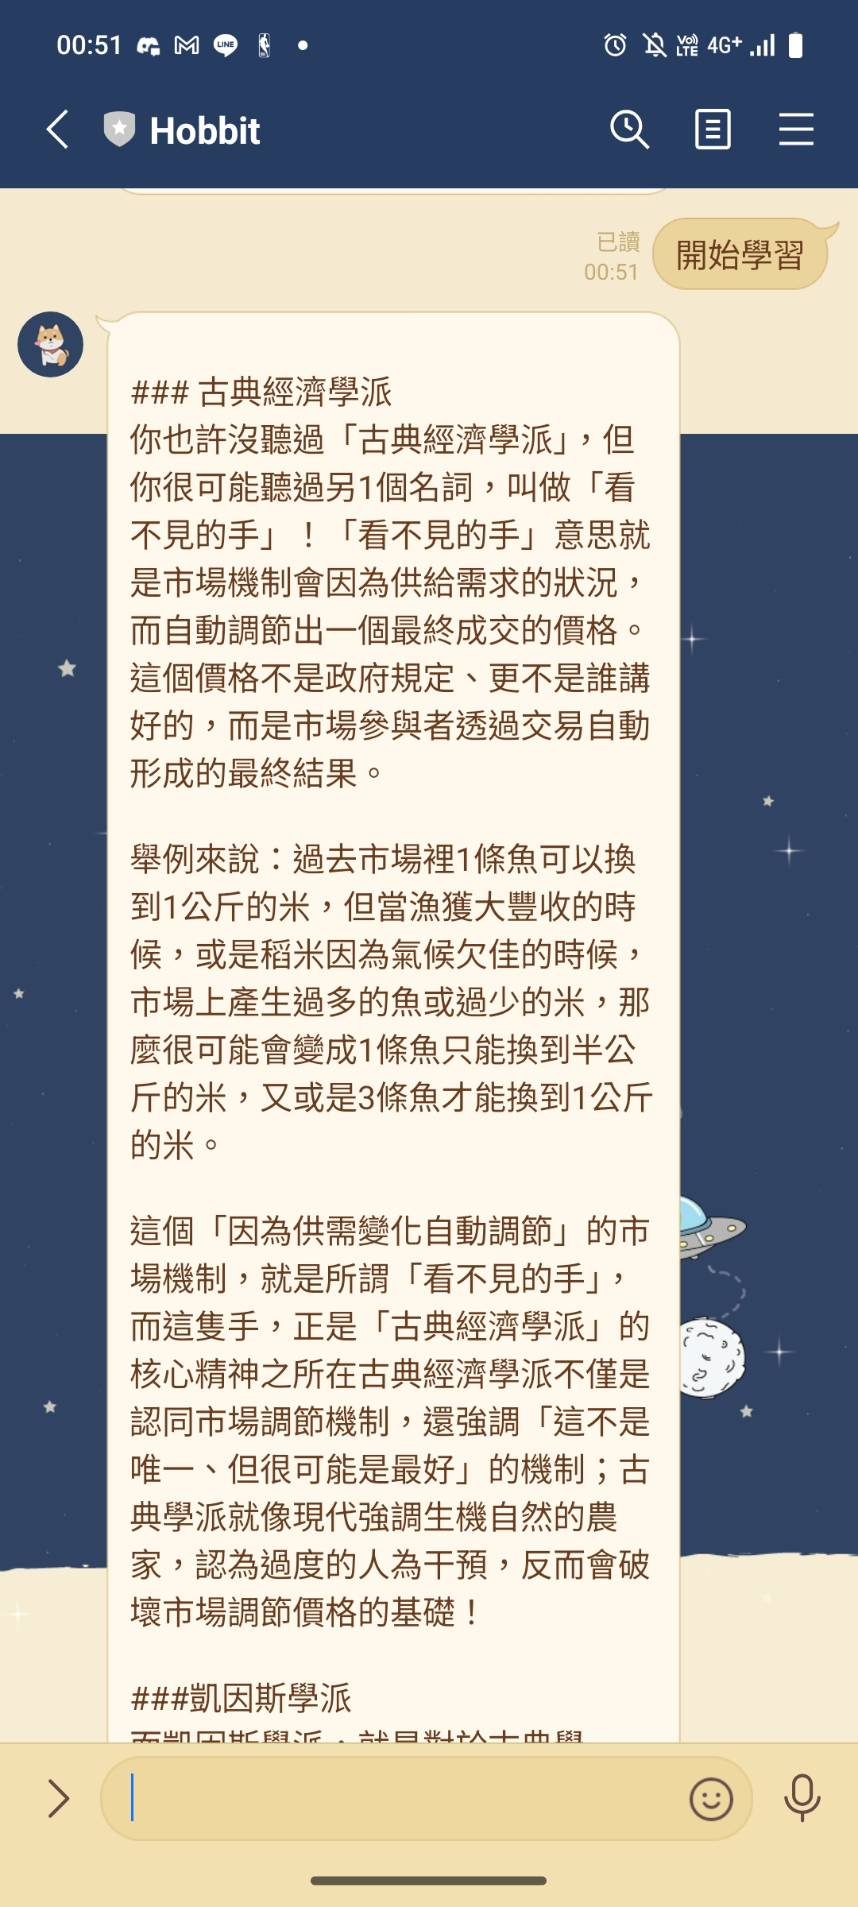

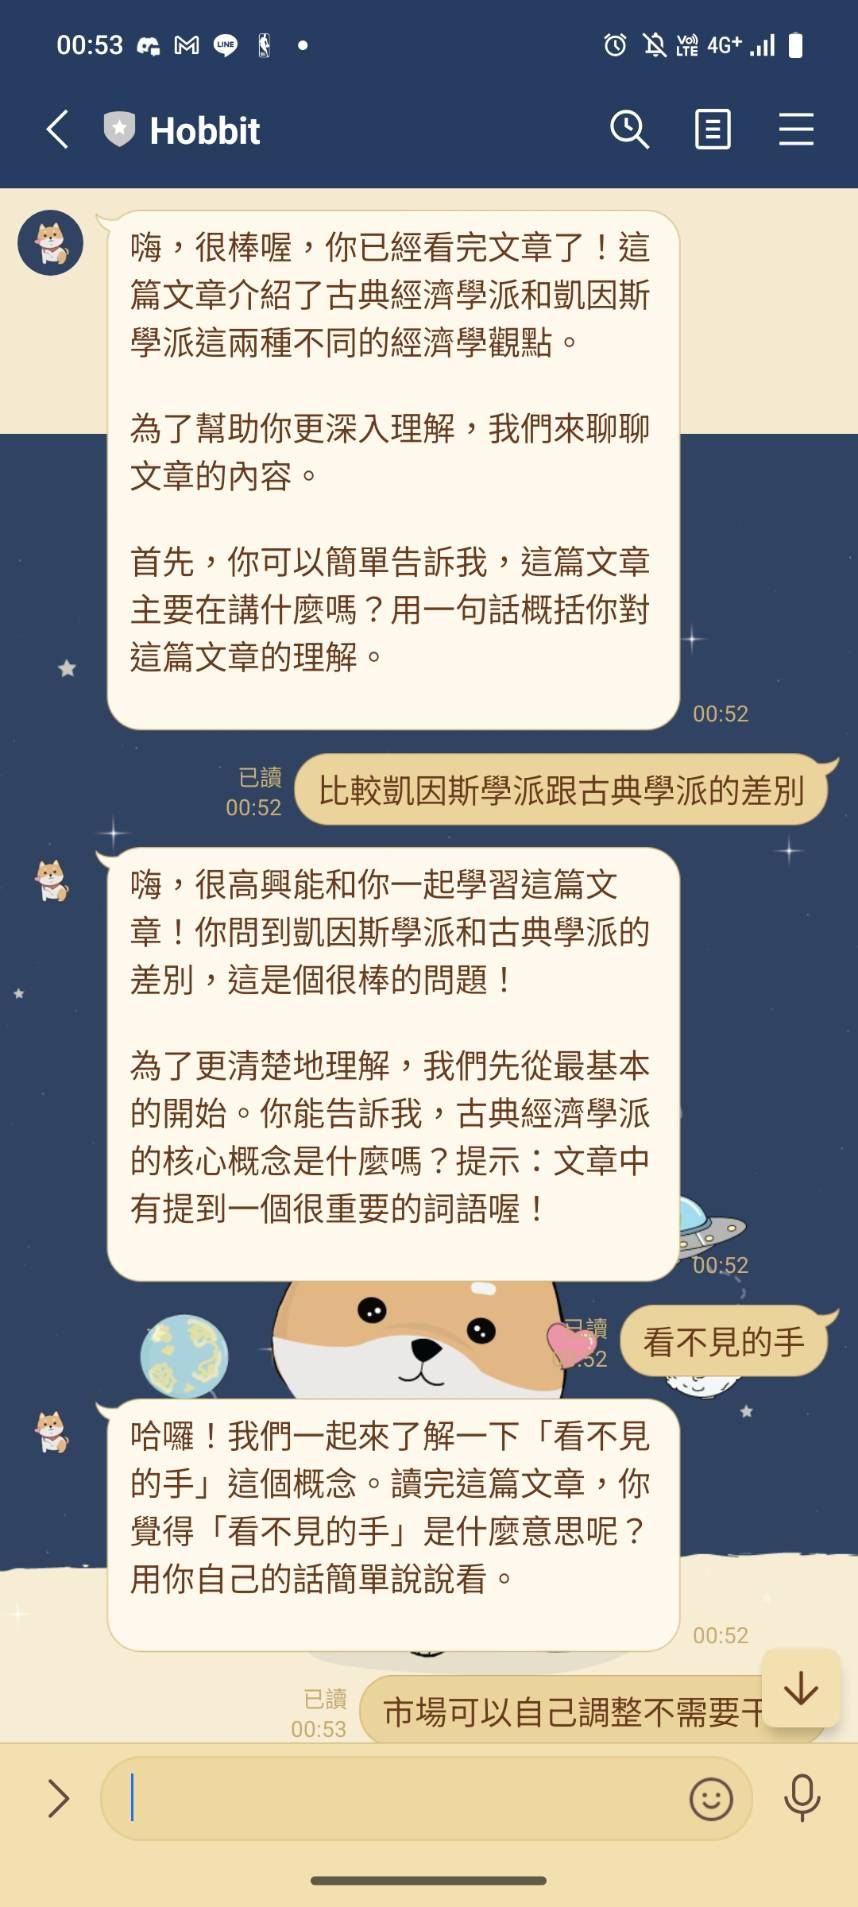

- 使用者於 LINE 傳送訊息：「開始學習」  
- LINE Bot 回應：指定經濟學文章
- 使用者：「詢問問題?」  
- Bot 回應：透過Gemini回答解答

### 效益分析

- 使用者測試報告

| 測試項目 | 測試結果 | 備註 |
|----------|----------|------|
| 功能完整性 | 80% 滿意 | 有時延遲,且會小跳針 |
| 界面設計 | 80% 滿意 | Line 介面熟悉 ||
| 建議回饋 | 加入上下文記憶 | 目前為單輪對話，後續可擴展為多輪記憶 |

- 系統是否達到目標？  
是的，能透過文章閱讀，學習知識並有gemini導師幫助很大。

## 未來發展與改進

### 改進建議  
- 加入「上下文記憶」功能，讓 AI 理解前後對話關聯  
- 增加延伸問題，並提供網路更多相關資料  
- 減少跳針問題出現

### 未來規劃  
- 可以產出經濟學圖表，更好理解  
- 可以提供更加專業知識